In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import metrics
import random
import matplotlib.pyplot as plt

In [2]:
def prepare_data(csv_link):
    """Prepare the Stanford Open Policing Data to be used in the classification model
    Parameters
    ----------
    csv_link : str
        The link of the data you want to do analysis on.
    race_included : int
        If you want the model to include race or not, 1 
        indicating race should be included, else race will not be included."""
    
    def convert_search(x):
        if x:
            return 1
        else:
            return 0
        
    def get_month(x):
        return int(x[5:7])
    
    def get_year(x):
        return int(x[:4])
    
    def time_gaps(x):
        if x >= '05:00:00' and x < '12:00:00':
            return 'Morning'
        elif x >= '12:00:00' and x < '17:00:00':
            return 'Afternoon'
        elif x >= '17:00:00' and x < '21:00:00':
            return 'Evening'
        elif x >= '21:00:00' and x < '05:00:00':
            return 'Night'
        
    def change_contraband(row):
        if row['is_searched'] == 1:
            return row['contraband_found']
        else:
            return False
        
    def failed_search(row):
        if row['is_searched'] == 1 and row['contraband_found'] == False:
            return 1
        else:
            return 0
        
    def improved_target(row):
        if row['is_searched'] == 1 and row['failed_search'] == 1:
            return 0
        elif row['is_searched'] == 0:
            return 0
        else:
            return 1
        
    def change_month(row):
        curr_month = row['month']
        curr_year = row['year']
        return 12*(year_lst.index(curr_year)+1)-(12-curr_month)    
    
    stanford_df = pd.read_csv(csv_link, low_memory = False)
    stanford_df = stanford_df.iloc[: , 1:]
    stanford_df = stanford_df[stanford_df['date'].notna()]
    stanford_df = stanford_df[stanford_df['time'].notna()]


    use_columns = ['date', 'time', 'subject_age', 'service_area', 'reason_for_stop', 'subject_race', 'subject_sex',
                           'type', 'search_conducted', 'contraband_found']

    # keep all columns that will help in prediction model
    stanford_df = stanford_df[use_columns]
    
    stanford_df = stanford_df[stanford_df['subject_race'].notna()]
    race_options = ['white', 'black']
    stanford_df = stanford_df[stanford_df['subject_race'].isin(race_options)]
    
    # get the month in a column
    stanford_df['month'] = stanford_df['date'].apply(get_month)
    
    # get the year in a column
    stanford_df['year'] = stanford_df['date'].apply(get_year)
    
    # get day of week name in column
    stanford_df['date'] = pd.to_datetime(stanford_df['date'])
    stanford_df['day of week'] = stanford_df['date'].dt.day_name()
    
    # change the month number for all the years
    year_lst = list(np.sort(stanford_df['year'].unique()))
    stanford_df['month'] = stanford_df.apply(change_month, axis=1)
    
    stanford_df = stanford_df[stanford_df['service_area'] != 'Unknown']
    stanford_df['time of day'] = stanford_df['time'].apply(time_gaps)
    stanford_df['is_searched'] = stanford_df['search_conducted'].apply(convert_search)
    stanford_df['contraband_found'] = stanford_df.apply(change_contraband, axis=1)
    stanford_df['failed_search'] = stanford_df.apply(failed_search, axis=1)
    stanford_df['improved_target'] = stanford_df.apply(improved_target, axis=1)
    
    stanford_df = stanford_df.dropna().reset_index()
    stanford_df = stanford_df.drop(['index','time', 'search_conducted', 'date', 'year', 'failed_search'], axis=1)
    return stanford_df

In [3]:
stanford_df = prepare_data('https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_ca_san_diego_2020_04_01.csv.zip')

In [4]:
# stanford_df = prepare_data('https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_tx_san_antonio_2020_04_01.csv.zip')

In [5]:
def eval_model(second_run):
    """Evaluate the Classification Model
    Parameters
    ----------
    second_run: Pandas DataFrame.
            DataFrame to evaluate the model on. """
    
    # analysis between runs
    overall_precision = metrics.precision_score(second_run['improved_target'], second_run['preds'], zero_division=0)
    overall_recall = metrics.recall_score(second_run['improved_target'], second_run['preds'], zero_division=0)
    
    black_drivers = second_run[second_run['subject_race_black'] == 1.0]
    white_drivers = second_run[second_run['subject_race_white'] == 1.0]

    black_precision = metrics.precision_score(black_drivers['improved_target'].values, black_drivers['preds'].values, zero_division=0)
    black_recall = metrics.recall_score(black_drivers['improved_target'].values, black_drivers['preds'].values, zero_division=0)

    white_precision = metrics.precision_score(white_drivers['improved_target'].values, white_drivers['preds'].values, zero_division=0)
    white_recall = metrics.recall_score(white_drivers['improved_target'].values, white_drivers['preds'].values, zero_division=0)

#     print('black precision: ' + str(black_precision) + '   black recall: ' + str(black_recall)) 
#     print('white precision: ' + str(white_precision) + '   white recall: ' + str(white_recall))
#     print(metrics.accuracy_score(second_run['improved_target'], second_run['preds']))
    return black_precision, white_precision, black_recall, white_recall, overall_precision, overall_recall

In [6]:
def flip_labels(data, contra, searched):
    """Get the Predictions and modify to make better Model
    Parameters
    ----------
    data : Pandas DataFrame 
        DataFrame that we want to modify to include 2 new columns
    contra : Series
        The column (Series) that contains if contraband was found or not
    searched : Series
        The column (Series) that contains if the driver was searched or not."""
    
    data['contraband_found'] = contra
    data['is_searched'] = searched
    
    contra_rate = np.mean(sum(data['contraband_found'] == True))
    
    def correct_label(row):
        if row['preds'] == 1 and row['improved_target'] == 0:
            if row['is_searched'] == 1 and row['contraband_found'] == False:
                return 0
            if row['is_searched'] == 0:
                choices = [0, 1]
                distribution = [1-contra_rate, contra_rate]
                return random.choices(choices, distribution)[0]
        elif row['preds'] == 1 and row['improved_target'] == 1:
            return 1
        elif row['preds'] == 0 and row['improved_target'] == 0:
            return 0
        elif row['preds'] == 0 and row['improved_target'] == 1:
            return 0
    
    
    temp = data.apply(correct_label, axis = 1)
    data['improved_target'] = temp
    data = data.drop(['contraband_found', 'is_searched', 'preds'], axis=1)
    
    return data

In [47]:
def make_model(data, race = 1, freq = 3):
    """Train and Make the Classification Model
    Parameters
    ----------
    data : Pandas DataFrame or str
        It can either be data that has already been cleaned to be used for 
        the model or the link of the data you want to do analysis on.
    race : int
        If you want the model to include race or not, 1 
        indicating race should be included, else race will not be included.
    freq : int
        How many months you want the model to train at a time. Can either 
        be 1,2,3,4,6."""
    
    if freq not in [1,2,3,4,6]:
        raise ValueError(f'Value "{freq}" is not allowed choose from 1, 2, 3, 4, 6.')
        
    # checks if given data is a link or dataframe already
    if type(data) == str:
        stanford_df = prepare_data(df, race)
    else:
        stanford_df = data
    
    save_race = stanford_df['subject_race']
    
    # checks if race is in dataframe to avoid any errors
#     if race == 1:
    cat_cols = ['subject_race','subject_sex', 'type','reason_for_stop', 'day of week', 'time of day']
#     else:
#         cat_cols = ['subject_sex', 'type','reason_for_stop', 'day of week', 'time of day']
#         stanford_df = stanford_df.drop(['subject_race'], axis=1)
    
    months = list(np.sort(stanford_df['month'].unique()))
    
    encoder = OneHotEncoder(sparse=False)

    # Encode Categorical Data
    df_encoded = pd.DataFrame(encoder.fit_transform(stanford_df[cat_cols]))
    df_encoded.columns = encoder.get_feature_names(cat_cols)

    # Replace Categotical Data with Encoded Data
    df_stanford_ready = stanford_df.drop(cat_cols ,axis=1)
    df_stanford_ready = pd.concat([df_encoded, df_stanford_ready], axis=1)
    
    first_months = months[:freq]
    second_months = months[freq:freq+freq]
    
    counter = 0
    
    black_pres = []
    black_rec = []
    white_pres = []
    white_rec = []
    
    overall_pres = []
    overall_rec = []
    
    count = 0
    
    for _ in range(int(len(months)/freq)-1):
        
        reg_rf = LinearDiscriminantAnalysis()
#         reg_rf = KNeighborsClassifier(n_neighbors=1)
#         reg_rf = DecisionTreeClassifier(random_state=0)
#         reg_rf = RandomForestClassifier()
        
        if counter == 0:        
            # df containing only the first freq months
            first_run = df_stanford_ready[df_stanford_ready['month'].isin(first_months)].reset_index().drop(['index'], axis=1)
            target = first_run['improved_target']
     
            first_run = first_run.drop(['improved_target', 'month', 'contraband_found', 'is_searched'], axis = 1).reset_index().drop(['index'], axis=1)
            
            if race == 0:
                first_run = first_run.drop(['subject_race_black'], axis = 1).reset_index().drop(['index'], axis=1)
                first_run = first_run.drop(['subject_race_white'], axis = 1).reset_index().drop(['index'], axis=1)
        else:
            target = first_run['improved_target']

            first_run = first_run.drop(['improved_target'], axis = 1).reset_index().drop(['index'], axis=1)
            
            if race == 0:
                first_run = first_run.drop(['subject_race_black'], axis = 1).reset_index().drop(['index'], axis=1)
                first_run = first_run.drop(['subject_race_white'], axis = 1).reset_index().drop(['index'], axis=1)
                
        # df containing the next freq months after the ones above
        second_run = df_stanford_ready[df_stanford_ready['month'].isin(second_months)].reset_index().drop(['index'], axis=1)
        second_run_target = second_run['improved_target']

        # save both columns for label flipping later on 
        save_contra_second = second_run['contraband_found']
        save_searched_second = second_run['is_searched']
        
        if race == 0:
            save_raceb_second = second_run['subject_race_black']
            save_racew_second = second_run['subject_race_white']
            second_run = second_run.drop(['month', 'improved_target', 'contraband_found', 'is_searched', 'subject_race_black', 'subject_race_white'], axis=1)
        else:           
            second_run = second_run.drop(['month', 'improved_target', 'contraband_found', 'is_searched'], axis=1)
        
        # fit the model
        reg_rf.fit(first_run, target)
        
        # predicting
        y_pred = reg_rf.predict(second_run)
        second_run['improved_target'] = second_run_target
        second_run['preds'] = y_pred
        
        if race == 0:
            second_run['subject_race_black'] = save_raceb_second
            second_run['subject_race_white'] = save_racew_second
        

#         print(sum(second_run[second_run['preds']==1]['subject_race_black']==1.0))
#         print(sum(second_run['preds']==1)-sum(second_run[second_run['preds']==1]['subject_race_black']==1.0))
#         print(second_run[second_run['preds']==1].groupby('service_area').count()['subject_race_black'])
#         print('\n')
        
        # evals the model
        if race == 1:
            black_precision, white_precision, black_recall, white_recall, overall_precision, overall_recall = eval_model(second_run)
            black_pres.append(black_precision)
            black_rec.append(black_recall)
            white_pres.append(white_precision)
            white_rec.append(white_recall)
            overall_pres.append(overall_precision)
            overall_rec.append(overall_recall)
            
#         print(first_months, second_months)
        
        first_run = flip_labels(second_run, save_contra_second, save_searched_second)
        
        first_months = second_months
        second_months = list(np.array(second_months)+freq)
        
        counter+=1
    return df_stanford_ready, black_pres, black_rec, white_pres, white_rec, overall_pres, overall_rec

In [49]:
final, black_pres, black_rec, white_pres, white_rec, overall_pres, overall_rec  = make_model(stanford_df, 1, 3)

In [50]:
def plot_evals(x1,x2,metric):
    if metric == 'precision':
        
        y = list(range(len(x1)))
        data = {'Iter': y,
            'Black': x1,
            'White': x2
           }
        df = pd.DataFrame(data,columns=['Iter','Black', 'White'])
        plt.plot(df['Iter'], df['Black'], color='red', marker='o')
        plt.plot(df['Iter'], df['White'], color='blue', marker='o')
        plt.title('Black Precision vs White Precision')
        plt.xlabel('Iteration')
        plt.ylabel('Precision')
        plt.legend(['Black', 'White'])
        
    if metric == 'recall':
        
        y = list(range(len(x1)))
        data = {'Iter': y,
            'Black': x1,
            'White': x2
           }
        df = pd.DataFrame(data,columns=['Iter','Black', 'White'])
        plt.plot(df['Iter'], df['Black'], color='red', marker='o')
        plt.plot(df['Iter'], df['White'], color='blue', marker='o')
        plt.title('Black Recall vs White Recall')
        plt.xlabel('Iteration')
        plt.ylabel('Recall')
        plt.legend(['Black', 'White'])
        
    if metric == 'all':
        
        y = list(range(len(x1)))
        data = {'Iter': y,
            'Black': x1,
            'White': x2
           }
        df = pd.DataFrame(data,columns=['Iter','Black', 'White'])
        plt.plot(df['Iter'], df['Black'], color='black', marker='o')
        plt.plot(df['Iter'], df['White'], color='green', marker='o')
        plt.title('Overall Precision/Recall')
        plt.xlabel('Iteration')
        plt.ylabel('Precision/Recall')
        plt.legend(['Precison', 'Recall'])

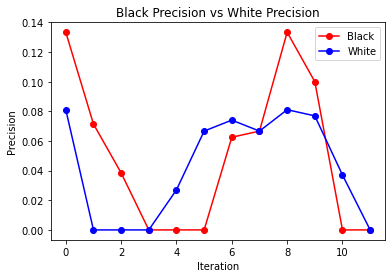

In [51]:
plot_evals(black_pres, white_pres, 'precision')

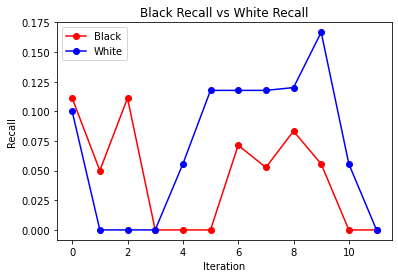

In [52]:
plot_evals(black_rec, white_rec, 'recall')

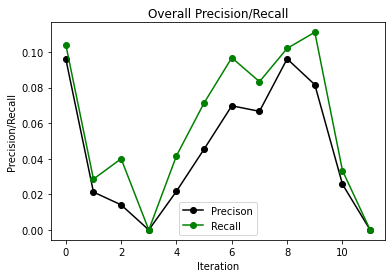

In [53]:
plot_evals(overall_pres, overall_rec, 'all')

In [54]:
final, black_pres, black_rec, white_pres, white_rec, overall_pres, overall_rec  = make_model(stanford_df, 0, 3)